In [1]:
# - f beta
# - predic_proba
# - look at categories more likely to succeed
# - classifying what stage the startup is on, whether or not you will invest on 


# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification #generates a random classification problem
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions #plotting regions
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.datasets.california_housing import fetch_california_housing
import sklearn.linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import sklearn.svm
from imblearn.over_sampling import ADASYN


# make prettier plots
# %config InlineBackend.figure_format = 'svg' 

Using TensorFlow backend.


In [2]:
df = pd.read_pickle("./raw_data.pkl")

In [3]:
df = df.drop(columns=('number_of_funding_rounds'))
df.shape

(7245, 55)

In [4]:
X = df.loc[:, df.columns != 'target']
y = df.target

#### Create ADASYN

In [5]:
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

In [53]:
X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn,y_adasyn 
                                                                                , test_size=0.2
                                                                                , random_state=42)

X_train_adasyn, X_val_adasyn, y_train_adasyn, y_val_adasyn = train_test_split(X_train_adasyn
                                                                              ,y_train_adasyn 
                                                                              , test_size=0.25
                                                                              , random_state=42)

In [7]:
Counter(y_adasyn)

Counter({0: 7020, 1: 7021})

#### XGBoost

In [54]:
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [55]:
xgb = XGBClassifier()
rand_search = RandomizedSearchCV(xgb,xgb_params, cv=5,scoring='recall',iid=True)
rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9926290684995872
{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 5, 'gamma': 1, 'colsample_bytree': 0.8}


In [36]:
clf = XGBClassifier().fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = clf.predict(X_val_adasyn)

In [37]:
y_pred_proba = clf.predict_proba(X_val_adasyn)[:,1] 
false_positive_rate_xgboost, true_positive_rate_xgboost, _ = roc_curve(y_val_adasyn,y_pred_proba)


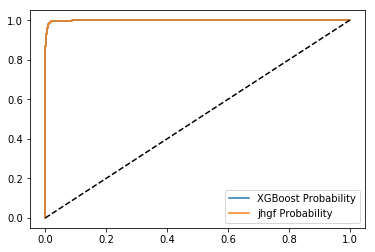

In [17]:


#titles, axis lables
#

In [15]:
recall = metrics.recall_score(y_val_adasyn,y_pred_adasyn)
print(f"Recall: {recall}")
print(f"FBeta: {metrics.fbeta_score(y_val_adasyn, y_pred_adasyn, average='macro', beta=0.4)}")
print(f"Precision: {metrics.precision_score(y_val_adasyn, y_pred_adasyn)}")

Recall: 0.992226148409894
FBeta: 0.9861866077600197
Precision: 0.9804469273743017


#### KNN

In [16]:
knn_param = {'n_neighbors' : range(1,100), 'algorithm':['auto', 'ball_tree','kd_tree','brute'], 
             'weights':['uniform', 'distance']}

In [17]:
knn = KNeighborsClassifier()
rand_search = RandomizedSearchCV(knn,knn_param, cv=5,scoring='recall',iid=True)
rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9279597980300919
{'weights': 'distance', 'n_neighbors': 13, 'algorithm': 'kd_tree'}


In [23]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=13, weights = 'distance', algorithm='kd_tree')
knn.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn_knn = knn.predict(X_val_adasyn)

print(f"Accuracy Score: {metrics.accuracy_score(y_val_adasyn, y_pred_adasyn_knn)}")
print(f"Recall Score: {metrics.recall_score(y_val_adasyn,y_pred_adasyn_knn)}")
print(f"F1 Score: {metrics.f1_score(y_val_adasyn,y_pred_adasyn_knn)}")
print(f"FBeta: {metrics.fbeta_score(y_val_adasyn, y_pred_adasyn_knn, average='macro', beta=0.4)}")
print(f"Precision: {metrics.precision_score(y_val_adasyn, y_pred_adasyn)}")
      

Accuracy Score: 0.9216524216524217
Recall Score: 0.9335689045936396
F1 Score: 0.923130677847659
FBeta: 0.9218201689660476
Precision: 0.9441301272984441


In [24]:
y_pred_proba = knn.predict_proba(X_val_adasyn)[:,1] 
false_positive_rate_knn, true_positive_rate_knn, _ = roc_curve(y_val_adasyn,y_pred_proba)


#### Decision Tree

In [18]:
decision_tree_param = {"class_weight": ['balanced',None],"max_depth": [3, None],
              "max_features": ['auto','sqrt','log2'],
              "min_samples_split": range(10,500,10),
              "criterion": ["gini", "entropy"],
                       'max_depth':range(1,10,2),
                      'random_state': [42]}



In [19]:
decision_tree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(decision_tree, decision_tree_param, cv=5,scoring='recall',iid=True)

rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9334234831056001
{'random_state': 42, 'min_samples_split': 20, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'gini', 'class_weight': None}


In [30]:
decision_tree = DecisionTreeClassifier(criterion='entropy',class_weight= None
                                       ,random_state = 42, max_features = 'auto', min_samples_leaf = 2
                                       ,min_samples_split = 10
                                       ,max_depth = 9)
decision_tree.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = decision_tree.predict(X_val_adasyn)


print(f"Accuracy Score: {metrics.accuracy_score(y_val_adasyn, y_pred_adasyn)}")
print(f"Recall Score: {metrics.recall_score(y_val_adasyn,y_pred_adasyn)}")
print(f"F1 Score: {metrics.f1_score(y_val_adasyn,y_pred_adasyn)}")
print(f"FBeta: {metrics.fbeta_score(y_val_adasyn, y_pred_adasyn, average='macro', beta=0.4)}")

Accuracy Score: 0.9433760683760684
Recall Score: 0.9434628975265018
F1 Score: 0.9437963944856841
FBeta: 0.9433712536832974


In [31]:
y_pred_proba = decision_tree.predict_proba(X_val_adasyn)[:,1] 
false_positive_rate_decision_tree, true_positive_rate_decision_tree, _ = roc_curve(y_val_adasyn,y_pred_proba)


#### Logistic Regression

In [21]:
logistic_regression_param = {"C":np.logspace(-4, 4, 20), "penalty":["l2"]}


In [22]:
logistic_regression = LogisticRegression(solver="lbfgs")
rand_search = RandomizedSearchCV(logistic_regression, logistic_regression_param, cv=5,scoring='recall',iid=True)

rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9360496163771823
{'penalty': 'l2', 'C': 0.0006951927961775605}


In [28]:
logistic_regression = LogisticRegression(penalty= 'l2', C=0.0001)
logistic_regression.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = logistic_regression.predict(X_val_adasyn)

print(f"Accuracy Score: {metrics.accuracy_score(y_val_adasyn, y_pred_adasyn)}")
print(f"Recall Score: {metrics.recall_score(y_val_adasyn,y_pred_adasyn)}")
print(f"F1 Score: {metrics.f1_score(y_val_adasyn,y_pred_adasyn)}")
print(f"FBeta: {metrics.fbeta_score(y_val_adasyn, y_pred_adasyn, average='macro', beta=0.4)}")

Accuracy Score: 0.7183048433048433
Recall Score: 0.9194346289752651
F1 Score: 0.7668729737695256
FBeta: 0.736729212689692


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [32]:
y_pred_proba = logistic_regression.predict_proba(X_val_adasyn)[:,1] 
false_positive_rate_logisitc, true_positive_rate_logistic, _ = roc_curve(y_val_adasyn,y_pred_proba)


In [31]:
log_coef = pd.DataFrame(logistic_regression.coef_, columns=X.columns)

log_coef = log_coef.melt()
# log_coef.sort_values(by=['value'], ascending = False)
log_coef

,variable,value
0,last_funding_amount,-3.188496e-08
1,number_of_founders,-3.126630e-12
2,number_of_investors,-7.086589e-12
3,number_of_lead_investors,-3.897882e-13
4,total_funding_amount,2.991418e-08
5,artificial_intelligence,-2.077445e-13
6,biotechnology,-9.359788e-15
7,data_and_analytics,-2.893374e-13
8,health_care,-1.670524e-13
9,science_and_engineering,-2.068581e-13


#### Random Forest

In [19]:
random_forest_param = {'n_estimators': [4,5,6,7,8, 9], 
              'max_features': ['log2', 'sqrt','auto',None],
              'criterion': ['entropy', 'gini'], 
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8],
              'class_weight' : ['balanced','balanced_subsample', None]}


In [20]:
random_forest = RandomForestClassifier(n_jobs = -1)
rand_search = RandomizedSearchCV(random_forest, random_forest_param, cv=5,scoring='recall',iid=True)

rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)


0.9812169658270801
{'n_estimators': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}


In [39]:
random_forest = RandomForestClassifier(n_estimators= 4, min_samples_split=2
                                       ,min_samples_leaf=4, max_features= 'auto', max_depth= 10
                                       , criterion= 'entropy'
                                       ,class_weight= None)

random_forest.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = random_forest.predict(X_val_adasyn)

print(f"Accuracy Score: {metrics.accuracy_score(y_val_adasyn, y_pred_adasyn)}")
print(f"Recall Score: {metrics.recall_score(y_val_adasyn,y_pred_adasyn)}")
print(f"F1 Score: {metrics.f1_score(y_val_adasyn,y_pred_adasyn)}")
print(f"FBeta: {metrics.fbeta_score(y_val_adasyn, y_pred_adasyn, average='macro', beta=0.4)}")
print(f"Precision: {metrics.precision_score(y_val_adasyn, y_pred_adasyn)}")


Accuracy Score: 0.9718660968660968
Recall Score: 0.9816254416961131
F1 Score: 0.9723486174308716
FBeta: 0.9720194050400465
Precision: 0.963245492371706


In [40]:
y_pred_proba = random_forest.predict_proba(X_val_adasyn)[:,1] 
false_positive_rate_random_forest, true_positive_rate_random_forest, _ = roc_curve(y_val_adasyn,y_pred_proba)


In [28]:
feat_importances = pd.Series(random_forest.feature_importances_, index=X.columns)

feat_import = pd.DataFrame(random_forest.feature_importances_, index=X.columns)


In [29]:
feat_import.sort_values(by = [0], ascending = False)

,0
total_funding_amount,0.536139
advertising,0.073845
number_of_investors,0.061834
days_since_founded,0.037323
software,0.034311
information_technology,0.030977
biotechnology,0.030810
number_of_lead_investors,0.023072
health_care,0.021152
days_since_last_funding,0.019810


#### SVC Model

In [201]:
svc_model_param = {'kernel':['linear', 'poly', 'rbf','sigmoid']
                   ,'gamma':[0.1, 1, 10, 100]
                   ,'C':[0.1, 1, 10, 100, 1000]
                   , 'degree':[0, 1, 2, 3, 4, 5, 6]}


In [202]:
svc_model = svm.SVC()
rand_search = RandomizedSearchCV(svc_model, svc_model_param, cv=5,scoring='recall',iid=True)

rand_search.fit(X_train_adasyn, y_train_adasyn)
print(rand_search.best_score_)
print(rand_search.best_params_)

In [203]:
svc_model = svm.SCV()

scv_model.fit(X_train_adasyn, y_train_adasyn)
y_pred_adasyn = scv_model.predict(X_val_adasyn)

print(f"Accuracy Score: {metrics.accuracy_score(y_val_adasyn, y_pred_adasyn)}")
print(f"Recall Score: {metrics.recall_score(y_val_adasyn,y_pred_adasyn)}")
print(f"F1 Score: {metrics.f1_score(y_val_adasyn,y_pred_adasyn)}")

#### ROC Plots

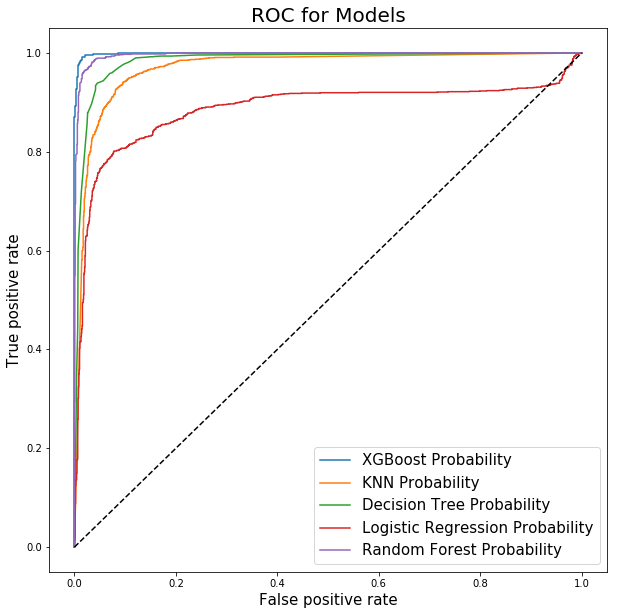

In [52]:
plt.figure(figsize=(10,10))
plt.title("ROC for Models",  fontsize = 20)
plt.plot(false_positive_rate_xgboost, true_positive_rate_xgboost, label = 'XGBoost Probability')
plt.plot(false_positive_rate_knn, true_positive_rate_knn, label = 'KNN Probability')
plt.plot(false_positive_rate_decision_tree, true_positive_rate_decision_tree, label = 'Decision Tree Probability')
plt.plot(false_positive_rate_logisitc, true_positive_rate_logistic, label = 'Logistic Regression Probability')
plt.plot(false_positive_rate_random_forest, true_positive_rate_random_forest, label= 'Random Forest Probability')
plt.xlabel('False positive rate', fontsize = 15)
plt.ylabel('True positive rate',  fontsize = 15)


plt.plot([0,1],[0,1],'k--')
plt.legend(fontsize = 15)
plt.show()
